In [1]:
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# Config
sns.set(color_codes=True)
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

### Imort general elections
Igore northern ireland

Make the ons_id the database index

2017 data was formatted differently, so just creating columns of every party's vote and %

In [2]:
ge15 = pd.read_csv("general_election-uk-2015-results.csv")
ge15 = ge15.rename({"Constituency ID": "ons_id"}, axis=1)
ge15= ge15[ge15['Region'] != 'Northern Ireland']
ge15.index = ge15['ons_id']

ge10 = pd.read_csv("general_election-uk-2010-results.csv")
ge10 = ge10.rename({"Constituency ID": "ons_id"}, axis=1)
ge10= ge10[ge10['Region'] != 'Northern Ireland']
ge10.index = ge15['ons_id']

ge15 = ge15.drop(columns='ons_id')

In [3]:
ge17 = pd.read_csv('2017 UKPGE electoral data 4.csv',encoding = "ISO-8859-1")
ge17 = ge17.rename(columns={'ONS Code':'ons_id'})
total_votes = ge17[['ons_id','Valid votes']].groupby('ons_id').sum()

p = {'ukip':'UKIP',
     'ld':'Liberal Democrats',
     'lab':'Labour',
     'con':'Conservative',
     'snp':'SNP',
     'grn':'Green Party'}

ge17 = ge17.merge(total_votes.rename(columns={'Valid votes':'total_votes'}), on='ons_id')
for party in p:
    mask = ge17['Party Identifer'] == p[party]
    ge17_party = ge17[mask].rename(columns={'Valid votes':party})
    ge17 = ge17.merge(ge17_party[['ons_id',party]],on='ons_id',how='left').fillna(0)
    ge17[party+'_pc'] = ge17[party] / ge17['total_votes']

ge17 = ge17[ ge17['Party Identifer']=='Labour' ]
ge17.index = ge17['ons_id']
ge17 = ge17.drop(columns='ons_id')
ge17.head()

,PANO,Constituency,Surname,First name,Party,Party Identifer,Valid votes,total_votes,ukip,ukip_pc,ld,ld_pc,lab,lab_pc,con,con_pc,snp,snp_pc,grn,grn_pc
ons_id,,,,,,,,,,,,,,,,,,,,
E14000530,7,Aldershot,PUFFETT,Gary John,Labour Party,Labour,15477,48950,1796.0,0.036691,3637.0,0.074300,15477.0,0.316180,26950.0,0.550562,0.0,0.0,1090.0,0.022268
E14000531,8,Aldridge-Brownhills,FISHER,John Gary,Labour Party,Labour,12010,40235,0.0,0.000000,1343.0,0.033379,12010.0,0.298496,26317.0,0.654082,0.0,0.0,0.0,0.000000
E14000532,9,Altrincham and Sale West,WESTERN,Andrew,Labour Party,Labour,20507,52790,0.0,0.000000,4051.0,0.076738,20507.0,0.388464,26933.0,0.510191,0.0,0.0,1000.0,0.018943
E14000533,11,Amber Valley,DAWSON,James Clifford Hedley,Labour Party,Labour,17605,45811,0.0,0.000000,1100.0,0.024012,17605.0,0.384296,25905.0,0.565476,0.0,0.0,650.0,0.014189
E14000534,18,Arundel and South Downs,FIFE,Caroline Joan,Labour Party,Labour,13690,60256,1668.0,0.027682,4783.0,0.079378,13690.0,0.227197,37573.0,0.623556,0.0,0.0,2542.0,0.042187


In [4]:
# some useful functions
def onsid_from_name(name):
    return ge17.index[ge17['Constituency']==name][0]

def name_from_onsid(onsid):
    return ge17['Constituency'].loc[onsid]

### Estimate marginal seats
If labour were won by a certain percentage, or were within a certain percentage of winning the seat (margin = 0.15). Rough estimate of seats of interest

This is so we can identify constituencies that actually had a campaign run in them.

In [5]:
opposition = ['con','ld','ukip','grn','snp']
parties = ['lab'] + opposition

margin = 0.15

ge17['winner'] = ge17[parties].T.apply(lambda x: x.nlargest(1).idxmin())
ge17['second'] = ge17[parties].T.apply(lambda x: x.nlargest(2).idxmin())
ge17['third']  = ge17[parties].T.apply(lambda x: x.nlargest(3).idxmin())
ge17['marginal'] = False

for row in ge17.T:
    win_party = ge17['winner'][row]
    win_vote  = ge17.loc[row][win_party+'_pc']
    sec_party = ge17['second'][row]
    sec_vote  = ge17.loc[row][sec_party+'_pc']
    thi_party = ge17['third'][row]
    thi_vote  = ge17.loc[row][thi_party+'_pc']
    if win_vote - sec_vote < margin:
        if 'lab' in [win_party,sec_party]:
            ge17['marginal'][row] = True
    if win_vote - thi_vote < margin:
        if thi_party == 'lab':
            ge17['marginal'][row] == True

sum(ge17['marginal'])

/Users/robertsinclair/anaconda3/envs/democracy/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


176

In [6]:
# Check constituency names are correct
#a = ge15['Constituency Name']
#b = ge17['Constituency']
#c = pd.concat([a,b],axis=1)
#for i in range(len(c.T)):
#    if c['Constituency Name'][i] != c['Constituency'][i]:
#        print(c.T[i])
#c

### Import census data
make ons_id the database index

In [7]:
census = pd.read_csv("census_file.csv")
census.index = census['ons_id']
census = census.drop(columns='ons_id')
census.head()

,Unnamed: 0,ons_region_id,constituency_name,county_name,region_name,Region,country_name,constituency_type17,BREXITLeave,declaration_time17,result17,Winner17,Turnout17,second17,electorate17,valid_votes17,invalid_votes17,majority17,con17,lab17,ld17,snp17,pc17,UKIP17,Green17,DUP17,SF17,SDLP17,UUP17,Alliance17,Other17,convote17,labvote17,ldvote17,ukipvote17,greenvote17,snpvote17,pcvote17,dupvote17,sfvote17,sdlpvote17,uupvote17,alliancevote17,othervote17,turnout1517,con1517,lab1517,ld1517,UKIP1517,SNP1517,PC1517,green1517,Constituency,pano,ConstituencyName,Country,Winner15,Con15,Lab15,LD15,SNP15,PC15,UKIP15,Green15,Other15,Majority15,Turnout15,ConVote15,LabVote15,LDVote15,SNPVote15,PCVote15,UKIPVote15,GreenVote15,BNPVote15,TotalVote15,Electorate15,SeatChange1015,Con1015,Lab1015,LD1015,SNP1015,PC1015,UKIP1015,Green1015,Winner10,Con10,Lab10,LD10,SNP10,PC10,UKIP10,Green10,BNP10,Majority10,Turn10,Convote10,Labvote10,LDvote10,SNPvote10,PCvote10,UKIPvote10,Greenvote10,BNPvote10,Elecorate10,ConPPC15,ConPPCsex15,ConPPCrace15,LabPCC15,LabPPCsex15,LabPPCrace15,LDPCC15,LDPPCsex15,LDPPCrace15,UKIPPPC15,UKIPPPCsex15,UKIPPPPCrace15,SNPPPC15,SNPPPCsex15,SNPPPCrace15,PCPPC15,PCPPCsex15,PCPPCrace15,GreenPPC15,GreenPPCsex15,GreenPPCrace15,c11Population,c11PopulationDensity,c11Male,c11Female,c11Households,c11Communal,c11Age0to4,c11Age5to7,c11Age8to9,c11Age10to14,c11Age15,c11Age16to17,c11Age18to19,c11Age20to24,c11Age25to29,c11Age30to44,c11Age45to59,c11Age60to64,c11Age65to74,c11Age75to84,c11Age85to89,c11Age90plus,c11HouseOwned,c11HouseOutright,c11HouseMortgage,c11HouseShared,c11HouseSocial,c11HouseSocialLA,c11HouseSocialOther,c11HousePrivate,c11HousePrivateLandlord,c11HousePrivateOther,c11HouseRentFree,c11HouseholdOnePerson,c11HouseholdOnePerson65plus,c11HouseholdOnePersonOther,c11HouseholdOneFamily,c11HouseholdOneFamily65plus,c11HouseholdMarried,c11HouseholdMarriedNoChildren,c11HouseholdMarriedDependents,c11HouseholdMarriedNondependents,c11HouseholdCohabit,c11HouseholdCohabitNoChildren,c11HouseholdCohabitDependents,c11HouseholdCohabitNodependents,c11HouseholdLone,c11HouseholdLoneDependents,c11HouseholdLoneNodependents,c11HouseholdOther,c11HouseholdOtherDependents,c11HouseholdAllStudents,c11HouseholdAll65plus,c11HouseholdAnyOther,c11CarsNone,c11CarsOne,c11CarsTwo,c11CarsThree,c11CarsFour,c11EthnicityWhite,c11EthnicityMixed,c11EthnicityAsian,c11EthnicityBlack,c11EthnicityOther,c11EthnicityWhiteBritish,c11EthnicityWhiteIrish,c11EthnicityWhiteTraveller,c11EthnicityWhiteOther,c11EthnicityMixedCaribbean,c11EthnicityMixedAfrican,c11EthnicityMixedAsian,c11EthnicityMixedOther,c11EthnicityIndian,c11EthnicityPakistani,c11EthnicityBangladeshi,c11EthnicityChinese,c11EthnicityOtherAsian,c11EthnicityBlackAfrican,c11EthnicityBlackCaribbean,c11EthnicityBlackOther,c11EthnicityArab,c11EthnicityAnyOther,c11BornUK,c11BornEngland,c11BornNI,c11BornScotland,c11BornWales,c11BornUKNotSpecified,c11BornIreland,c11BornOtherEU,c11BornOtherPre2004EU,c11BornPost2004EU,c11BornOther,c11PassportNone,c11PassportAny,c11PassportUK,c11PassportIreland,c11PassportEU,c11PassportEuropeNotEU,c11PassportAfrica,c11PassportAsia,c11PassportNorthAmerica,c11PassportCentralAmerica,c11PassportSouthAmerica,c11PassportOceania,c11EnglishAll,c11EnglishOne,c11EnglishChild,c11EnglishNone,c11Christian,c11Buddhist,c11Hindu,c11Jewish,c11Muslim,c11Sikh,c11ReligionOther,c11NoReligion,c11ReligionNotStated,c11NSSECHigherManager,c11NSSECHigherProfessional,c11NSSECLowerManager,c11NSSECIntermediate,c11NSSECSmallEmployer,c11NSSECLowerSupervisor,c11NSSECSemiRoutine,c11NSSECRoutine,c11NSSECNeverWorked,c11NSSECLongtermUnemployed,c11EconomicActive,c11Employed,c11EmployedPartTime,c11EmployedFullTime,c11SelfEmployed,c11Unemployed,c11EconomicallyActiveStudent,c11EconomicInactive,c11Retired,c11EconomicallyInactiveStudent,c11LookingAfterHome,c11LongTermSick,c11EconomicInactiveOther,c11Unemployed16to24,c11Unemployed50to74,c11Neverworked,c11LongTermUnemployed,c11FulltimeStudent,c11IndustryAgriculture,c11IndustryMining,c11Industry

In [37]:
census.sort_values('c11Population')[['c11Population','constituency_name']]

,c11Population,constituency_name
ons_id,,
S14000027,27684.0,Na h-Eileanan An Iar
S14000051,44516.0,Orkney and Shetland
W07000058,56415.0,Aberconwy
W07000057,60573.0,Arfon
W07000061,61301.0,Dwyfor Meirionnydd
S14000009,62229.0,"Caithness, Sutherland and Easter Ross"
W07000063,63779.0,Montgomeryshire
W07000049,66133.0,Aberavon
S14000055,67967.0,"Ross, Skye and Lochaber"


In [8]:
# Combine latest election with census data 
ge17_census = ge17.merge(census.drop(columns=['Region','Constituency']),left_index=True, right_index=True,validate='one_to_one')

### Pick relevant demographics
We want to identify similar constituencies in terms of what effects vote; but not including vote history

I've tried a few combinations, not sure if best to have lots of data of less.... currently gone with only 9 features, chosen arbitrarily 

In [9]:
demographics = {'c11PopulationDensity':0.5,
                'c11Households':1,
                'c11HouseOwned':1,
                'c11CarsNone':1,
                'c11EthnicityWhite':1,
                'c11EthnicityMixed':1,
                'c11EthnicityAsian':1,
                'c11EthnicityBlack':1,
                'c11EthnicityOther':1,
                'c11BornUK':1,
                'c11Christian':1,
                'c11Buddhist':1,
                'c11Hindu':1,
                'c11Jewish':1,
                 'c11Muslim':1,
                 'c11Sikh':1,
                 'c11ReligionOther':1,
                 'c11NoReligion':1,
                 'c11Unemployed':10,
                 'c11Retired':10,
                 'c11FulltimeStudent':10,
                 'c11Age0to4':0.5,
                 'c11Age5to7':0.3,
                 'c11Age8to9':0.2,
                 'c11Age10to14':0.5,
                 'c11Age15':0.1,
                 'c11Age16to17':0.2,
                 'c11Age18to19':0.2,
                 'c11Age20to24':0.5,
                 'c11Age25to29':0.5,
                 'c11Age30to44':1.5,
                 'c11Age45to59':1.5,
                 'c11Age60to64':0.5,
                 'c11Age65to74':1,
                 'c11Age75to84':1,
                 'c11Age85to89':0.5,
                 'c11Age90plus':0.5,
                 'c11DeprivedNone':1,
                 'c11Deprived1':1,
                 'c11Deprived2':1,
                 'c11Deprived3':1,
                 'c11Deprived4':1}

demographics = {'c11PopulationDensity':0.5,
                'c11HouseOwned':1,
                'c11CarsNone':1,
                'c11EthnicityWhite':1,
                 'c11Unemployed':10,
                 'c11Retired':10,
                 'c11FulltimeStudent':10,
                 'c11Age65to74':1,
                 'c11DeprivedNone':1}

demographics = list(demographics.keys())

In [10]:
mask = ge17_census['marginal'] == True
constit_demog = ge17_census[mask][['Constituency']+demographics]
constit_demog.dropna(inplace=True)

### Cluster constituencies 

KMeans is the simplest clustering algorithm. We don't want any pattern inference (i think), just group similar constituencies by demographic together.

Number of clusters is arbitrarily... 

In [11]:
from sklearn import preprocessing
X = constit_demog[demographics]
X_scaled = preprocessing.scale(X)

In [12]:
def get_clusters(names,labels):
    n_clusters = max(labels)
    clusters = {}
    for cluster in range(n_clusters):
        mask = labels == cluster
        similar = list(names[mask])
        clusters[cluster] = similar
    return clusters

In [13]:
from sklearn.cluster import KMeans

n_clusters=40

# Ive declared the random_state just to make sure we can compare things
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
kmeans.fit(X)

kmeans_clusters = get_clusters(constit_demog.index,
                               kmeans.labels_)
#kmeans_clusters

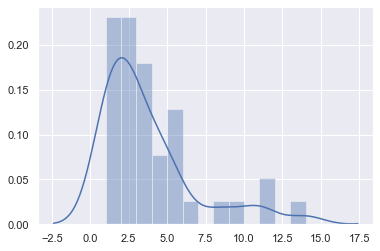

In [14]:
cluster_sizes = [len(x) for x in kmeans_clusters.values()]
sns.distplot(cluster_sizes,bins=range(max(cluster_sizes)+1),norm_hist=False)

In [15]:
# view the demographic data of any cluster, check they are somewhat similar 
constit_demog[kmeans.labels_ == 0]

,Constituency,c11PopulationDensity,c11HouseOwned,c11CarsNone,c11EthnicityWhite,c11Unemployed,c11Retired,c11FulltimeStudent,c11Age65to74,c11DeprivedNone
ons_id,,,,,,,,,,
E14000908,Rushcliffe,3.070021,76.405380,15.476342,92.488653,2.758170,15.607843,9.211329,9.348904,54.778673
E14000922,"Sheffield, Hallam",5.459412,77.321394,17.856458,92.295985,2.331485,15.484807,17.257219,9.563991,56.154331
E14001062,York Outer,3.770519,81.539065,15.395871,96.012466,2.116433,18.055272,11.749701,10.765060,53.051999


### How good were the campaigns
We need a measure of how succesful the last campaign was. Here I'm just making it the difference in votes from 2015 to 2017. Ideally we would use something like labour's own forecasting, or data on how much was invested in a campaign, or polls etc

In [16]:
lab_change = pd.DataFrame([ge15['lab'],ge17['lab']],index=[15,17]).T
lab_change['change'] = lab_change[17] - lab_change[15]
lab_change.head()

,15,17,change
W07000049,15416.0,22662.0,7246.0
W07000058,8514.0,13702.0,5188.0
S14000001,11397.0,11031.0,-366.0
S14000002,12991.0,9143.0,-3848.0
S14000058,2487.0,5706.0,3219.0


make a useful database `data`, that calculates the how good the campaign was relevant to the others in the cluster. Basically trying to remove the naitonal campaign so we can figure out which local campaigns did well.

In [17]:
data = pd.DataFrame()

for cluster in kmeans_clusters:
    constituencies = kmeans_clusters[cluster]
    swings = []
    for constit in constituencies:
        swings += [lab_change.loc[constit]['change']]
        
    for constit,swing in zip(constituencies,swings):
        if len(swings) == 1: sigma_from_mean = 0
        else: sigma_from_mean = (swing-np.mean(swings))/np.std(swings)
        line = pd.DataFrame({
            'ons_id':constit,
            'constituency':name_from_onsid(constit),
            'cluster':cluster,
            'cluster_size':len(swings),
            'mean':np.mean(swings),
            'std':np.std(swings),
            'change':swing,
            'sigma_from_mean':sigma_from_mean,
            'dist_from_mean':swing - np.mean(swings)
        },index=[0])
        data = data.append(line,ignore_index=True,sort=False)

In [18]:
data[data['constituency']=='Lancaster and Fleetwood']

,ons_id,constituency,cluster,cluster_size,mean,std,change,sigma_from_mean,dist_from_mean
138,E14000776,Lancaster and Fleetwood,37,2,6050.5,1648.5,7699.0,1.0,1648.5


In [19]:
# best local campaigns
data.sort_values(by='dist_from_mean',ascending=False).head(5)

,ons_id,constituency,cluster,cluster_size,mean,std,change,sigma_from_mean,dist_from_mean
135,E14001003,Truro and Falmouth,36,11,7530.545455,2221.532778,13517.0,2.694741,5986.454545
94,E14000682,East Worthing and Shoreham,26,8,5818.000000,2300.798448,11145.0,2.315283,5327.000000
7,E14000616,Camborne and Redruth,2,11,5227.727273,2002.406738,9976.0,2.371283,4748.272727
34,E14000822,Milton Keynes South,10,5,6236.400000,2207.030639,10058.0,1.731557,3821.600000
68,E14000619,Canterbury,17,3,8667.000000,2720.939666,12452.0,1.391064,3785.000000


In [20]:
ge17_cluster = ge17.merge(data.rename(columns={'constituency':'Constituency'}),on="Constituency")

In [21]:
cols = ['Constituency','marginal','sigma_from_mean','dist_from_mean','change',
        'cluster','cluster_size','winner','con','lab','ld','snp']
ge17_cluster[cols].sort_values(by='dist_from_mean',ascending=False).head(5)

,Constituency,marginal,sigma_from_mean,dist_from_mean,change,cluster,cluster_size,winner,con,lab,ld,snp
108,Truro and Falmouth,True,2.694741,5986.454545,13517.0,36,11,con,25123.0,21331.0,8465.0,0.0
39,East Worthing and Shoreham,True,2.315283,5327.000000,11145.0,26,8,con,25988.0,20882.0,2523.0,0.0
18,Camborne and Redruth,True,2.371283,4748.272727,9976.0,2,11,con,23001.0,21424.0,2979.0,0.0
65,Milton Keynes South,True,1.731557,3821.600000,10058.0,10,5,con,30652.0,28987.0,1895.0,0.0
19,Canterbury,True,1.391064,3785.000000,12452.0,17,3,lab,25385.0,25572.0,4561.0,0.0


In [22]:
best_labour_campaigns = ge17_cluster[cols].sort_values(by='dist_from_mean',ascending=False).head(10)['Constituency'].values
best_labour_campaigns

array(['Truro and Falmouth', 'East Worthing and Shoreham',
       'Camborne and Redruth', 'Milton Keynes South', 'Canterbury',
       'South Thanet', 'Bridgend', 'Colchester', 'Alyn and Deeside',
       'Plymouth, Sutton and Devonport'], dtype=object)

In [23]:
def find_worst_similar_constit(best,data):
    cluster = int(data['cluster'][data['constituency']==best])
    clusterdata = data[data['cluster']==cluster]
    smallest_swing = clusterdata['change'].idxmin()
    return data['constituency'].loc[smallest_swing]

for i in range(len(best_labour_campaigns)):
    print(best_labour_campaigns[i],',',find_worst_similar_constit(best_labour_campaigns[i],data))

Truro and Falmouth , Rossendale and Darwen
East Worthing and Shoreham , Nuneaton
Camborne and Redruth , Dwyfor Meirionnydd
Milton Keynes South , Thurrock
Canterbury , Loughborough
South Thanet , Bolsover
Bridgend , North East Derbyshire
Colchester , Lincoln
Alyn and Deeside , North East Derbyshire
Plymouth, Sutton and Devonport , Southampton, Itchen


From the above data, the best campaigns are in quite large clusters, so hard to pick out all the information. Milton Keynes South performed well, and is in a small cluster so I've chosen that as an example.

## Is this useful???

Declare the cluster you are interested in and the following cells will make some useful stats on it...

All the constituencies in the group improved their votes for labour, but by varying amounts.

In [24]:
cluster = 10

In [25]:
data[data['cluster']==cluster].sort_values(by='dist_from_mean',ascending=False)

,ons_id,constituency,cluster,cluster_size,mean,std,change,sigma_from_mean,dist_from_mean
34,E14000822,Milton Keynes South,10,5,6236.4,2207.030639,10058.0,1.731557,3821.6
33,E14000652,Crawley,10,5,6236.4,2207.030639,6666.0,0.194651,429.6
35,E14000890,Reading West,10,5,6236.4,2207.030639,6003.0,-0.105753,-233.4
36,E14000968,Stevenage,10,5,6236.4,2207.030639,5076.0,-0.525774,-1160.4
37,E14000995,Thurrock,10,5,6236.4,2207.030639,3379.0,-1.294681,-2857.4


In [26]:
ge17_cluster[ge17_cluster['cluster']==cluster].sort_values(by='dist_from_mean',ascending=False)

,PANO,Constituency,Surname,First name,Party,Party Identifer,Valid votes,total_votes,ukip,ukip_pc,ld,ld_pc,lab,lab_pc,con,con_pc,snp,snp_pc,grn,grn_pc,winner,second,third,marginal,ons_id,cluster,cluster_size,mean,std,change,sigma_from_mean,dist_from_mean
65,398,Milton Keynes South,O`NEILL,Hannah Frances,Labour Party,Labour,28987,64546,1833.0,0.028398,1895.0,0.029359,28987.0,0.449091,30652.0,0.474886,0.0,0.0,1179.0,0.018266,con,lab,ld,True,E14000822,10,5,6236.4,2207.030639,10058.0,1.731557,3821.6
29,168,Crawley,LUNNON,Timothy George,Labour Party,Labour,22969,50273,0.0,0.000000,1878.0,0.037356,22969.0,0.456885,25426.0,0.505759,0.0,0.0,0.0,0.000000,con,lab,ld,True,E14000652,10,5,6236.4,2207.030639,6666.0,0.194651,429.6
82,465,Reading West,BAILEY,Olivia Joanna,Labour Party,Labour,22435,51766,0.0,0.000000,3041.0,0.058745,22435.0,0.433393,25311.0,0.488950,0.0,0.0,979.0,0.018912,con,lab,ld,True,E14000890,10,5,6236.4,2207.030639,6003.0,-0.105753,-233.4
100,532,Stevenage,TAYLOR,Sharon Jane,Labour & Co-Operative Party,Labour,21412,49327,0.0,0.000000,2032.0,0.041194,21412.0,0.434083,24798.0,0.502727,0.0,0.0,1085.0,0.021996,con,lab,ld,True,E14000968,10,5,6236.4,2207.030639,5076.0,-0.525774,-1160.4
107,571,Thurrock,KENT,John George,Labour Party,Labour,19535,50325,10112.0,0.200934,798.0,0.015857,19535.0,0.388177,19880.0,0.395032,0.0,0.0,0.0,0.000000,con,lab,ukip,True,E14000995,10,5,6236.4,2207.030639,3379.0,-1.294681,-2857.4


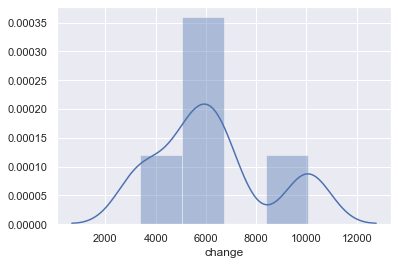

In [27]:
sns.distplot(data[data['cluster']==cluster]['change'])

In [28]:
import geopandas as gpd

map_df = gpd.read_file("map.shp")
map_df.index = census.index

In [29]:
def highlight_constits(map_df,constits):
    ids = []
    for constit in constits:
        ids += [ onsid_from_name(constit) ]
    highlight_map = map_df
    highlight_map['color'] = 0.9
    L = len(ids)
    for i,id_ in enumerate(ids):
        highlight_map['color'][id_] = i*0.5/L 
    return highlight_map

In [30]:
constits = data[data['cluster']==cluster].sort_values(by='dist_from_mean',ascending=False)['constituency']
constits

34    Milton Keynes South
33                Crawley
35           Reading West
36              Stevenage
37               Thurrock
Name: constituency, dtype: object

/Users/robertsinclair/anaconda3/envs/democracy/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


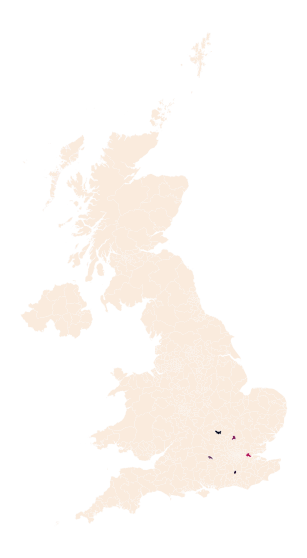

In [31]:
hmap = highlight_constits(map_df,constits)
f, ax = plt.subplots(1, figsize=(10, 10))
ax = hmap.plot(column=hmap['color'],ax=ax,linewidth=0.1)
ax.set_axis_off()

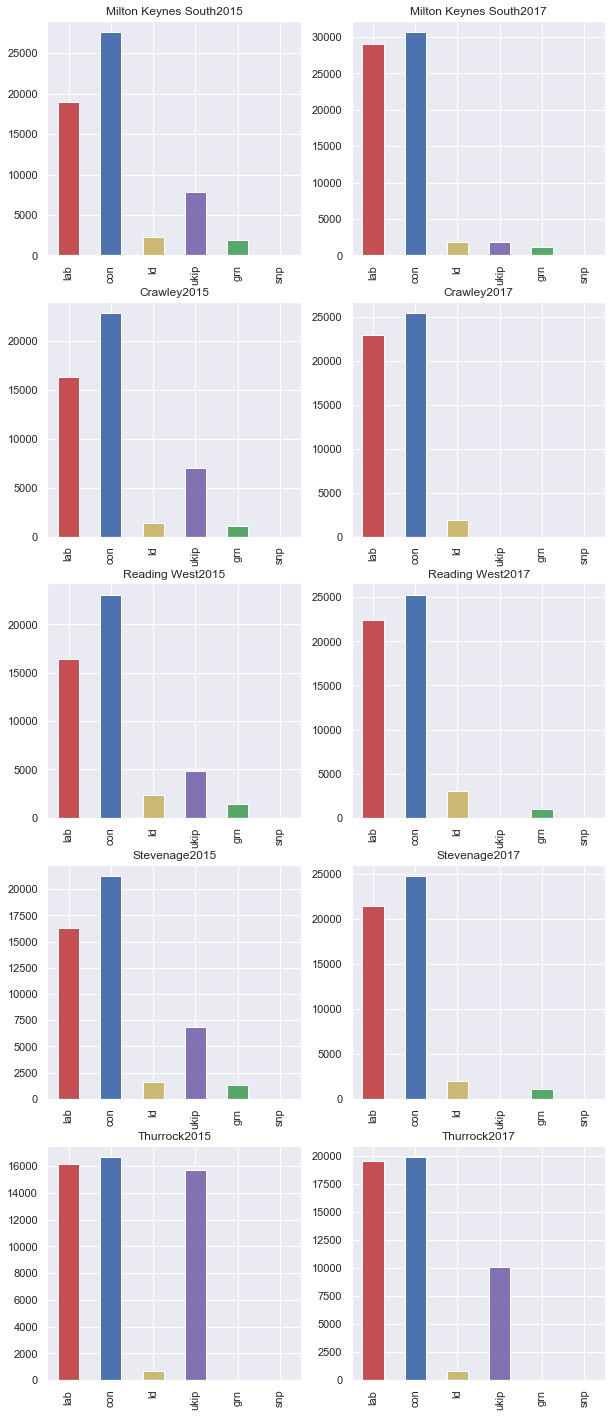

In [32]:
fig, ax = plt.subplots(len(constits),2,figsize=(10,5*len(constits)))

for i,constit in enumerate(constits):
    onsid = onsid_from_name(constit)
    #plt.figure(i)
    
    ge15[parties].loc[onsid].plot.bar(color=['r','b','y','m','g','y'],title=constit+'2015',ax=ax[i,0])
    
    ge17[parties].loc[onsid].plot.bar(color=['r','b','y','m','g','y'],title=constit+'2017',ax=ax[i,1])
    #sns.distplot(data[data['cluster']==i]['change'])

In [33]:
constit_demog[constit_demog['Constituency'].isin(constits)]

,Constituency,c11PopulationDensity,c11HouseOwned,c11CarsNone,c11EthnicityWhite,c11Unemployed,c11Retired,c11FulltimeStudent,c11Age65to74,c11DeprivedNone
ons_id,,,,,,,,,,
E14000652,Crawley,23.703656,59.044632,22.440143,79.908440,4.512075,9.480530,6.194084,5.879152,42.057715
E14000822,Milton Keynes South,15.888421,57.244261,18.599536,80.069751,4.730645,10.268481,6.707663,6.209899,46.372871
E14000890,Reading West,19.957205,63.802555,22.697964,80.886309,4.515152,11.047856,6.214926,7.181923,45.040933
E14000968,Stevenage,14.852823,59.775269,21.354498,88.487345,4.582675,11.469849,7.001228,7.431629,44.986878
E14000995,Thurrock,17.114294,61.586562,22.284195,82.497097,6.027867,10.159960,6.190944,5.841469,37.141052


Actual labour forcast/expected votes

How much money per constituency campaign 

Incumbency ???

House prices 

Local press 

How does marginal effect result?
Dont ignore anomolies that aren't marginal 

Noise of model, ensemble results 